[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Tutorial 1 - Spike Encoding
## By Jason K. Eshraghian (www.ncg.ucsc.edu)


<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_1_spikegen.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


이 snnTorch 튜토리얼 시리즈는 다음 논문을 기반으로 작성되었습니다. 이 자료나 코드를 작업에 활용하신다면, 아래의 출처를 인용해 주시기 바랍니다.:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

이 튜토리얼에서는 snnTorch를 사용하여 다음 내용을 학습하게 됩니다.:
* 데이터셋을 스파이크 데이터셋으로 변환하는 방법,
* 변환된 데이터를 시각화하는 방법,
* 무작위 스파이크 열(random spike train)을 생성하는 방법.

# Introduction
빛은 망막이 광자를 스파이크로 변환할 때 우리가 보게 되는 것입니다. 냄새는 기화된 분자가 스파이크로 변환될 때 우리가 맡게 되는 것입니다. 촉각은 신경 말단이 촉각 압력을 스파이크로 변환할 때 우리가 느끼게 됩니다. 뇌는 *Spike*라는 공통 통화를 사용합니다.

최종 목표가 SNN(Spiking Neural Network)을 구축하는 것이라면, 입력 역시 스파이크를 사용하는 것이 타당합니다.
물론 Tutorial 3에서 보게 되듯이 비스파이크 입력을 사용하는 경우도 흔하지만, 데이터를 인코딩하는 매력 중 일부는 생물학적인 처리 과정을 모사하는 데 있습니다.



1.   **Spikes**: (a-b) 생물학적 뉴런은 약 100 mV 진폭의 전기적 충격(spike)을 통해 정보를 처리하고 전달합니다. (c) 많은 뉴런의 계산 모델은 이러한 전압 펄스를 단일 비트 이벤트(‘1’ 또는 ‘0’)로 단순화합니다. 이는 고정밀 값을 사용하는 것보다 하드웨어에서 훨씬 간단하게 표현할 수 있습니다.

2.   **Sparsity**: (c) 뉴런은 대부분의 시간을 안정 상태로 보내며, 어느 시점이든 대부분의 활성화를 0으로 유지합니다. 0이 많은 희소 벡터/텐서는 저장 비용이 저렴할 뿐 아니라, 예를 들어 희소 활성화 값을 시냅스 가중치와 곱해야 한다고 할 때, 대부분의 값이 ‘0’이면 네트워크 파라미터를 메모리에서 읽을 필요가 거의 없습니다. 이는 뉴로모픽 하드웨어가 매우 효율적으로 동작할 수 있음을 의미합니다.

3.   **Static-Suppression (a.k.a, event-driven processing**: (d-e) 감각 주변부는 처리할 새로운 정보가 있을 때만 정보를 처리합니다. (e)의 각 픽셀은 조도(illuminance)의 변화에만 반응하므로, 이미지 대부분이 차단됩니다. 전통적인 신호 처리 방식에서는 모든 채널/픽셀이 전역 샘플링 속도나 셔터 속도를 따라야 하기 때문에 센싱 빈도가 느려집니다. 이벤트 기반 처리는 변하지 않는 입력을 차단함으로써 희소성과 전력 효율성을 높일 뿐만 아니라, 더 빠른 처리 속도를 가능하게 합니다.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/3s.png?raw=true' width="600">
</center>

이 튜토리얼에서는 non-spiking 형태의 입력 데이터(예: MNIST 데이터셋)를 가지고 있다고 가정하고, 이를 몇 가지 다른 기법을 사용하여 스파이크로 인코딩하는 과정을 다룹니다.
그럼 시작해봅시다!

먼저, snnTorch의 최신 PyPi 배포판을 설치합니다:

In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.7 MB/s eta 0:00:00


## 1. Setting up the MNIST Dataset

### 1.1. Import packages and setup environment

In [2]:
import snntorch as snn
import torch

In [3]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Torch Variables
dtype = torch.float

### 1.2 Download Dataset

In [4]:
from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.20MB/s]


위의 코드 블록에서 오류가 발생한다면, 예를 들어 MNIST 서버가 다운된 경우, 아래 코드를 주석 해제하여 대신 사용하세요.

In [ ]:
# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)

실제로 네트워크 학습을 시작하기 전까지는 큰 데이터셋이 필요하지 않습니다. `snntorch.utils`에는 데이터셋을 수정하는 데 유용한 몇 가지 함수가 포함되어 있습니다. `data_subset`을 적용하면 `subset`에 지정된 비율만큼 데이터셋을 줄일 수 있습니다. *예: `subset=10`인 경우, 60,000개의 학습 세트가 6,000개로 줄어듭니다.*


In [5]:
from snntorch import utils

subset = 10
mnist_train = utils.data_subset(mnist_train, subset)
print(f"The size of mnist_train is {len(mnist_train)}")

The size of mnist_train is 6000


### 1.3 Create DataLoaders
위에서 생성한 Dataset 객체는 데이터를 메모리에 로드하며, DataLoader는 이를 배치 단위로 제공합니다.
PyTorch의 DataLoader는 네트워크에 데이터를 전달하기 위한 편리한 인터페이스입니다.
`batch_size` 크기로 나뉜 미니배치 단위의 이터레이터를 반환합니다.


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

## 2. Spike Encoding

Spiking Neural Networks(SNNs)는 시간에 따라 변하는 데이터를 활용하도록 설계되었습니다.
그러나 MNIST는 시간 변화가 없는 데이터셋입니다.
MNIST를 SNN에서 사용하려면 두 가지 방법이 있습니다.

1. 동일한 학습 샘플 \$\mathbf{X}\in\mathbb{R}^{m\times n}\$을 각 시간 스텝마다 네트워크에 반복적으로 전달하는 방법입니다.
   이는 MNIST를 정적이고 변하지 않는 비디오로 변환하는 것과 같습니다.
   \$\mathbf{X}\$의 각 원소는 0과 1 사이로 정규화된 고정밀 값을 가질 수 있습니다: \$X\_{ij}\in \[0, 1]\$.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_1_static.png?raw=true' width="700">
</center>

2. 입력을 시퀀스 길이 num_steps의 스파이크 열(spike train)로 변환하는 방법입니다.
이 경우 각 특징/픽셀은 이산 값$X_{i,j} \in \{0, 1\}$을 갖습니다.
이렇게 하면 MNIST가 원본 이미지와 관련성을 유지하는 시간 변화 스파이크 시퀀스로 변환됩니다.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_2_spikeinput.png?raw=true' width="700">
</center>

첫 번째 방법은 꽤 간단하지만 SNN의 시간적 동역학을 충분히 활용하지 못합니다.
그래서 (2)에서 말한 데이터→스파이크 변환(인코딩)을 더 자세히 살펴보겠습니다.

`snntorch.spikegen` 모듈(스파이크 생성)은 데이터를 스파이크로 바꾸는 과정을 단순화하는 여러 함수를 제공합니다.
현재 `snntorch`에서 사용할 수 있는 스파이크 인코딩 옵션은 세 가지입니다.


1. Rate coding: [`spikegen.rate`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.rate)
2. Latency coding: [`spikegen.latency`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.latency)
3. Delta modulation: [`spikegen.delta`](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html#snntorch.spikegen.delta)

이들의 차이는 다음과 같습니다.

1. **Rate coding**: 입력 특징을 사용해 스파이크 **빈도**를 결정합니다.
2. **Latency coding**: 입력 특징을 사용해 스파이크 **발생 시점**을 결정합니다.
3. **Delta modulation**: 입력 특징의 시간적 **변화량**을 이용해 스파이크를 생성합니다.


### 2.1 Rate coding of MNIST

입력 데이터를 rate code로 변환하는 한 가지 예시는 다음과 같습니다.
정규화된 각 입력 특징 \$X\_{ij}\$를, 임의의 시간 스텝에서 이벤트(스파이크)가 발생할 확률로 사용하여 rate-coded 값 \$R\_{ij}\$를 생성합니다.
이는 베르누이 시행으로 볼 수 있습니다: \$R\_{ij} \sim B(n, p)\$, 여기서 시행 횟수는 \$n=1\$, 성공(스파이크 발생) 확률은 \$p = X\_{ij}\$입니다.
즉, 스파이크가 발생할 확률은 다음과 같습니다:

${\rm P}(R_{ij}=1) = X_{ij} = 1 - {\rm P}(R_{ij} = 0)$

 ‘0.5’로 채워진 벡터를 만들고, 위의 기법을 사용해 인코딩해 봅니다.


In [23]:
# Temporal Dynamics
num_steps = 10

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"Converted vector: {rate_coded_vector}")

print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

Converted vector: tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 1.])
The output is spiking 40.00% of the time.


이제 `raw_vector`의 길이를 늘려서 다시 시도해 보겠습니다.


In [29]:
num_steps = 100

# create vector filled with 0.5
raw_vector = torch.ones(num_steps)*0.5

# pass each sample through a Bernoulli trial
rate_coded_vector = torch.bernoulli(raw_vector)
print(f"The output is spiking {rate_coded_vector.sum()*100/len(rate_coded_vector):.2f}% of the time.")

The output is spiking 47.00% of the time.


`num_steps`가 $\rightarrow\infty$로 갈수록, 스파이크의 비율은 원래의 raw 값에 수렴합니다.

MNIST 이미지의 경우, 이 스파이크 발생 확률은 해당 픽셀 값에 해당합니다.

* 흰색 픽셀 → 스파이크 발생 확률 100%
* 검은색 픽셀 → 스파이크가 절대 발생하지 않음

아래의 ‘Rate Coding’ 열을 보면 이 개념을 더 직관적으로 이해할 수 있습니다.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_3_spikeconv.png?raw=true' width="1000">
</center>

비슷한 방식으로, `spikegen.rate`를 사용하면 데이터의 **rate-coded** 샘플을 생성할 수 있습니다.
MNIST의 각 샘플은 단순히 한 장의 이미지이므로, `num_steps`를 이용해 이를 시간 축을 따라 반복할 수 있습니다.


In [30]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

입력이 $[0,1]$ 범위를 벗어나면, 이는 더 이상 확률을 나타내지 않습니다.
이러한 경우에는 해당 특징이 확률을 나타내도록 자동으로 클리핑됩니다.

입력 데이터의 구조는 `[num_steps x batch_size x input dimensions]` 형식입니다.


In [31]:
print(spike_data.size())

torch.Size([100, 128, 1, 28, 28])


### 2.2 Visualization

#### 2.2.1 Animation
snnTorch에는 스파이킹 뉴런을 시각화하고, 플로팅하며, 애니메이션으로 표현하는 과정을 단순화하는 [`snntorch.spikeplot`](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html) 모듈이 포함되어 있습니다.



In [33]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

하나의 데이터 샘플을 플로팅하려면, `spike_data`의 배치(B) 차원에서 단일 샘플을 인덱싱하면 됩니다.
`spike_data`의 구조는 `[T x B x 1 x 28 x 28]`입니다.


In [34]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

torch.Size([100, 28, 28])


`spikeplot.animator`를 사용하면 2D 데이터를 매우 간단하게 애니메이션으로 만들 수 있습니다.
참고: 노트북을 로컬에서 실행하는 경우, `ffmpeg`를 설치해야 할 수 있습니다. 예를 들어,

* pip 환경: `pip install ffmpeg`
* Conda 환경: `conda install -c conda-forge ffmpeg`

만약 `ffmpeg`를 찾을 수 없다는 오류가 발생하면, 아래 줄의 주석을 해제하고 `ffmpeg.exe`의 경로를 수정해 주세요.


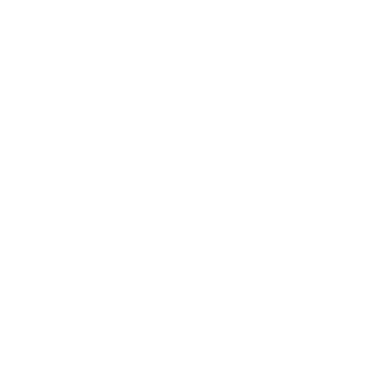

In [35]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)
# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

HTML(anim.to_html5_video())

In [36]:
# If you're feeling sentimental, you can save the animation: .gif, .mp4 etc.
anim.save("spike_mnist_test.mp4")

해당 샘플의 정답 라벨은 다음과 같이 인덱싱할 수 있습니다:

In [37]:
print(f"The corresponding target is: {targets_it[0]}")

The corresponding target is: 6


MNIST는 흑백(그레이스케일) 이미지이며, 흰색 픽셀은 매 시간 스텝마다 100% 스파이크가 발생합니다.
이번에는 스파이크 빈도를 줄여보겠습니다.
이때 `gain` 인자를 설정하면 됩니다.
여기서는 스파이크 빈도를 25%로 낮춰보겠습니다.


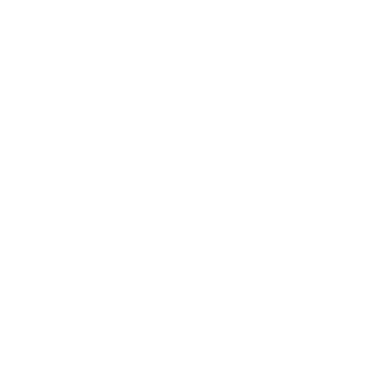

In [38]:
spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)

spike_data_sample2 = spike_data[:, 0, 0]
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample2, fig, ax)
HTML(anim.to_html5_video())

In [39]:
# Uncomment for optional save
# anim.save("spike_mnist_test2.mp4")

이제 시간 축 전체에서 스파이크를 평균내어 입력 이미지를 재구성하세요.


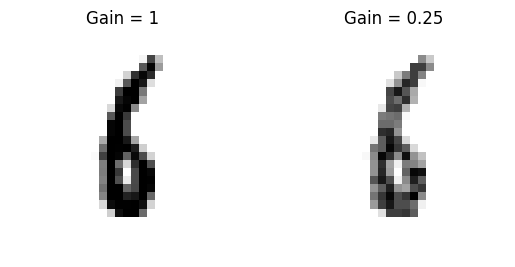

In [40]:
plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()

`gain=0.25`인 경우는 `gain=1`일 때보다 더 옅게 보입니다. 스파이크 발생 확률이 $\times 4$만큼 감소했기 때문입니다.


#### 2.2.2 Raster Plots


또 다른 방법으로, 입력 샘플의 **raster plot**을 생성할 수 있습니다. 이를 위해 샘플을 2차원 텐서로 **재구성(reshape)**해야 하며, 첫 번째 차원이 **시간(time)**이 되도록 합니다. 그런 다음 이 샘플을 `spikeplot.raster` 함수에 전달하면 됩니다.


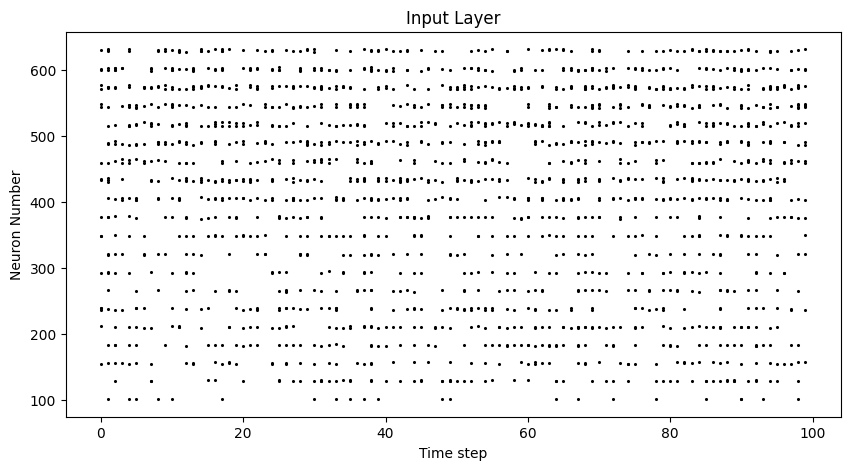

In [41]:
# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

다음 코드 예시는 단일 뉴런에 인덱싱하는 방법을 보여줍니다.
입력 데이터에 따라, 실제로 스파이크가 발생하는 뉴런을 찾으려면 0부터 784 사이에서 몇 가지 뉴런을 시도해 봐야 할 수도 있습니다.


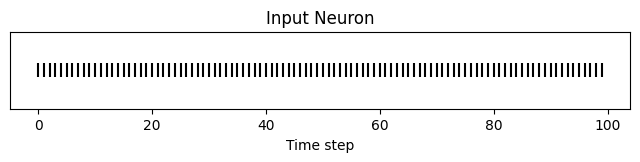

In [42]:
idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

#### 2.2.3 Rate Coding 요약

Rate coding의 개념은 사실 꽤 논란이 있습니다. 감각 주변부에서 rate coding이 일어난다는 점에는 비교적 확신이 있지만, 대뇌피질이 전반적으로 정보를 스파이크율로 부호화한다고는 확신하지 못합니다. 그 이유로 몇 가지 설득력 있는 근거가 있습니다:

* **전력 소비:** 자연은 효율성을 위해 최적화되어 있습니다. 어떤 작업을 수행하려면 여러 번의 스파이크가 필요하고, 각 스파이크는 전력을 소비합니다. 실제로 [Olshausen과 Field의 "What is the other 85% of V1 doing?" 연구](http://www.rctn.org/bruno/papers/V1-chapter.pdf)에서는 rate coding이 1차 시각 피질(V1) 뉴런 활동의 최대 15%만 설명할 수 있다고 보여줍니다. 자원 제약이 크고 매우 효율적인 뇌에서 이것이 유일한 메커니즘일 가능성은 낮습니다.

* **반응 속도:** 인간의 반응 시간은 대략 250ms 정도입니다. 인간 뇌 뉴런의 평균 발화율이 약 10Hz라면, 우리의 반응 시간 내에 약 2번의 스파이크만 처리할 수 있습니다.

그렇다면 전력 효율이나 지연(latency) 측면에서 최적이 아닌 rate code를 왜 사용할까요? 뇌가 데이터를 스파이크율로 처리하지 않더라도, 생물학적 센서는 그렇게 처리한다고 꽤 확신합니다. 전력/지연의 단점은 큰 노이즈 강인성을 보여줌으로써 일부 상쇄됩니다. 일부 스파이크가 생성되지 않아도, 그 자리를 채울 충분히 많은 스파이크가 존재하기 때문입니다.

또한, 여러분은 ["함께 발화하는 뉴런은 함께 연결된다"는 Hebbian 격언](https://doi.org/10.2307/1418888)을 들어본 적이 있을 것입니다. 스파이크가 많이 발생한다면 학습도 많이 일어날 가능성이 있습니다. SNN 학습이 어려운 경우, rate code를 통해 발화를 늘리는 것이 하나의 해결책이 될 수 있습니다.

Rate coding은 거의 확실히 뇌 속의 다른 부호화 방식들과 함께 작동하고 있습니다. 다음 절에서 이러한 다른 부호화 메커니즘들을 살펴보겠습니다.
여기까지가 `spikegen.rate` 함수에 대한 설명입니다. 더 많은 정보는 [여기 문서](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html)에서 확인할 수 있습니다.


### 2.3 Latency Coding of MNIST
Temporal codes capture information about the precise firing time of neurons; a single spike carries much more meaning than in rate codes which rely on firing frequency. While this opens up more susceptibility to noise, it can also decrease the power consumed by the hardware running SNN algorithms by orders of magnitude.

`spikegen.latency` is a function that allows each input to fire at most **once** during the full time sweep.
Features closer to `1` will fire earlier and features closer to `0` will fire later. I.e., in our MNIST case, bright pixels will fire earlier and dark pixels will fire later.

The following block derives how this works. If you've forgotten circuit theory and/or the math means nothing to you, then don't worry! All that matters is: **big** input means **fast** spike; **small** input means **late** spike.


---
**Optional: Derivation of Latency Code Mechanism**

By default, spike timing is calculated by treating the input feature as the current injection $I_{in}$ into an RC circuit. This current moves charge onto the capacitor, which increases $V(t)$. We assume that there is a trigger voltage, $V_{thr}$, which once reached, generates a spike. The question then becomes: *for a given input current (and equivalently, input feature), how long does it take for a spike to be generated?*

Starting with Kirchhoff's current law, $I_{in} = I_R + I_C$, the rest of the derivation leads us to a logarithmic relationship between time and the input.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_4_latencyrc.png?raw=true' width="600">
</center>

---

The following function uses the above result to convert a feature of intensity $X_{ij}\in [0,1]$ into a latency coded response $L_{ij}$.

In [ ]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time

Now, use the above function to visualize the relationship between input feature intensity and its corresponding spike time.


In [ ]:
raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()

The smaller the value, the later the spike occurs with exponential dependence.

The vector `spike_times` contains the time at which spikes are triggered, rather than a sparse tensor that contains the spikes themselves (1's and 0's).
When running an SNN simulation, we need the 1/0 representation to obtain all of the advantages of using spikes.
This whole process can be automated using `spikegen.latency`, where we pass a minibatch from the MNIST dataset in `data_it`:

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)

Some of the arguments include:

* `tau`:  the RC time constant of the circuit. By default, the input features are treated as a constant current injected into an RC circuit. A higher ``tau`` will induce slower firing.
* `threshold`: the membrane potential firing threshold. Input values below this threshold do not have a closed-form solution, as the input current is insufficient to drive the membrane up to the threshold. All values below the threshold are clipped and assigned to the final time step.

#### 2.3.1 Raster plot

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# optional save
# fig.savefig('destination_path.png', format='png', dpi=300)

To make sense of the raster plot, note that high intensity features fire first, whereas low intensity features fire last:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_5_latencyraster.png?raw=true' width="800">
</center>

The logarithmic code coupled with the lack of diverse input values (i.e., the lack of midtone/grayscale features) causes significant clustering in two areas of the plot.
The bright pixels induce firing at the start of the run, and the dark pixels at the end.
We can increase `tau` to slow down the spike times, or linearize the spike times by setting the optional argument `linear=True`.

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

The spread of firing times is much more evenly distributed now. This is achieved by linearizing the logarithmic equation according to the rules shown below. Unlike the RC model, there is no physical basis for the model. It's just simpler.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_6_latencylinear.png?raw=true' width="600">
</center>


But note how all firing occurs within the first ~5 time steps, whereas the simulation range is 100 time steps.
This indicates that we have a lot of redundant time steps doing nothing. This can be solved by either increasing `tau` to slow down the time constant, or setting the optional argument `normalize=True` to span the full range of `num_steps`.

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

One major advantage of latency coding over rate coding is sparsity. If neurons are constrained to firing a maximum of once over the time course of interest, then this promotes low-power operation.

In the scenario shown above, a majority of the spikes occur at the final time step, where the input features fall below the threshold. In a sense, the dark background of the MNIST sample holds no useful information.

We can remove these redundant features by setting `clip=True`.

In [ ]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01,
                              clip=True, normalize=True, linear=True)

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

That looks much better!

#### 2.3.2 Animation
We will run the exact same code block as before to create an animation.

In [ ]:
spike_data_sample = spike_data[:, 0, 0]
print(spike_data_sample.size())

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_data_sample, fig, ax)

HTML(anim.to_html5_video())

This animation is obviously much tougher to make out in video form, but a keen eye will be able to catch a glimpse of the initial frame where most of the spikes occur.
Index into the corresponding target value to check its value.

In [ ]:
# Save output: .gif, .mp4 etc.
# anim.save("mnist_latency.gif")

In [ ]:
print(targets_it[0])

That's it for the `spikegen.latency` function. Further information [can be found in the documentation here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

### 2.4 Delta Modulation
There are theories that the retina is adaptive: it will only process information when there is something new to process. If there is no change in your field of view, then your photoreceptor cells are  less prone to firing.

That is to say: **biology is event-driven**. Neurons thrive on change.

As a nifty example, a few researchers have dedicated their lives to designing retina-inspired image sensors, for example, the [Dynamic Vision Sensor](https://ieeexplore.ieee.org/abstract/document/7128412/). Although [the attached link is from over a decade ago, the work in this video](https://www.youtube.com/watch?v=6eOM15U_t1M&ab_channel=TobiDelbruck) was ahead of its time.

Delta modulation is based on event-driven spiking. The `snntorch.delta` function accepts a time-series tensor as input. It takes the difference between each subsequent feature across all time steps. By default, if the difference is both *positive* and *greater than the threshold $V_{thr}$*, a spike is generated:

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial1/1_2_7_delta.png?raw=true' width="600">
</center>

To illustrate, let's first come up with a contrived example where we create our own input tensor.

In [ ]:
# Create a tensor with some fake time-series data
data = torch.Tensor([0, 1, 0, 2, 8, -20, 20, -5, 0, 1, 0])

# Plot the tensor
plt.plot(data)

plt.title("Some fake time-series data")
plt.xlabel("Time step")
plt.ylabel("Voltage (mV)")
plt.show()

Pass the above tensor into the `spikegen.delta` function, with an arbitrarily selected `threshold=4`:

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

There are three time steps where the difference between $data[T]$ and $data[T+1]$ is greater than or equal to $V_{thr}=4$. This means there are three *on-spikes*.

The large dip to $-20$ has not been captured above. If negative swings have importance in your data, you can enable the optional argument `off_spike=True`.

In [ ]:
# Convert data
spike_data = spikegen.delta(data, threshold=4, off_spike=True)

# Create fig, ax
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

# Raster plot of delta converted data
splt.raster(spike_data, ax, c="black")

plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.xlim(0, len(data))
plt.show()

We've generated additional spikes, but this isn't actually the full picture!

Printing out the tensor will show the presence of "off-spikes" which take on a value of `-1`.

In [ ]:
print(spike_data)

While `spikegen.delta` has only been demonstrated on a fake sample of data, its true use is to compress time-series data by only generating spikes for sufficiently large changes/events.

That wraps up the three main spike conversion functions! There are still additional features to each of the three conversion techniques that have not been detailed in this tutorial. In particular, we have only looked at encoding input data; we have not considered how we might encode targets, and when that is necessary. We recommend [referring to the documentation for a deeper dive](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html).

## 3. Spike Generation (Optional)
Now what if we don't actually have any data to start with?
Say we just want a randomly generated spike train from scratch. Inside of
`spikegen.rate` is a nested function, `rate_conv`, which actually performs the  spike conversion step.

All we have to do is initialize a randomly generated `torchTensor` to pass in.

In [ ]:
# Create a random spike train
spike_prob = torch.rand((num_steps, 28, 28), dtype=dtype) * 0.5
spike_rand = spikegen.rate_conv(spike_prob)

### 3.1 Animation

In [ ]:
fig, ax = plt.subplots()
anim = splt.animator(spike_rand, fig, ax)

HTML(anim.to_html5_video())

In [ ]:
# Save output: .gif, .mp4 etc.
# anim.save("random_spikes.gif")

### 3.2 Raster

In [ ]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_rand[:, 0].view(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

# Conclusion

That's it for spike conversion and generation.
This approach generalizes beyond images, to single-dimensional and multi-dimensional tensors.

For reference, the documentation for [`spikegen` can be found here](https://snntorch.readthedocs.io/en/latest/snntorch.spikegen.html) and for [`spikeplot`, here](https://snntorch.readthedocs.io/en/latest/snntorch.spikeplot.html)

[In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), you will learn the basics of spiking neurons and how to use them.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.

# Additional Resources

* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)